In [1]:
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
import matplotlib.animation as animation

import collections
import statistics
import tensorflow as tf
from typing import Any, List, Sequence, Tuple

# from tf_env.UR_ENV import UR_env


In [2]:
class simple_env():
    def __init__(self, step_size=13,targets=[166,-88],max_steps=100):
        self.pos=np.random.uniform(-10,10,len(targets))
        self.max_steps=max_steps
        self.step_size=step_size
        self.targets=targets
        self.max_num=1000
        self.min_num=-1000
        self.done=False
        self.def_size_pos=[abs(targets[i]-self.pos[i]) for i in range(len(targets))]
        self.size_pos=[abs(targets[i]-self.pos[i]) for i in range(len(targets))]
        self.counter_stop=0
        self.obsevation_space=len(targets)
        self.action_space=len(targets)
        
    def reset(self):
        self.pos=np.random.uniform(-10,10,len(self.targets))
        self.size_pos=[abs(self.targets[i]-self.pos[i]) for i in range(len(self.targets))]
        self.counter_stop=0
        return self.pos

    def step(self,action):
        self.counter_stop+=1
        if self.counter_stop>=self.max_steps:
            self.done=True
        self.last_pos=np.copy(self.pos) 
        self.last_size_pos=np.copy(self.size_pos)
        self.reward=np.zeros(self.pos.shape)
        for i in range(len(action)):
            self.pos[i]=self.pos[i]+(action[i]*self.step_size)
            self.size_pos[i]=abs(self.targets[i]-self.pos[i])
            difference= self.last_size_pos[i]-self.size_pos[i]
            self.reward[i]=difference/self.def_size_pos[i]
        return self.pos, self.reward, self.done

In [3]:
number_iterations = 100 # @param {type:"integer"}
max_anglular_velocity = 2
max_steps_env = 40
discount = 0.95 # @param {type:"number"}


fc_layer_params=(300,300)
learning_rate = 1e-5 # @param {type:"number"}



num_states = 2
num_actions = 2

upper_bound = 1.
lower_bound = -1.

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
eps = np.finfo(np.float32).eps.item()# заменяет числа 0< минимальным неотрицательным

In [5]:
env= simple_env()

In [6]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [7]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03)

    inputs = tf.keras.layers.Input(shape=(num_states,))
    out = tf.keras.layers.Dense(256, activation="relu")(inputs)
    out = tf.keras.layers.Dense(256, activation="relu")(out)
    outputs = tf.keras.layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = tf.keras.layers.Input(shape=(num_states))
    state_out = tf.keras.layers.Dense(16, activation="relu")(state_input)
    state_out = tf.keras.layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = tf.keras.layers.Input(shape=(num_actions))
    action_out = tf.keras.layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = tf.keras.layers.Concatenate()([state_out, action_out])

    out = tf.keras.layers.Dense(256, activation="relu")(concat)
    out = tf.keras.layers.Dense(256, activation="relu")(out)
    outputs = tf.keras.layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()
# for var in critic_model.trainable_variables:
#   print(var, "\n")

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.5
actor_lr = 0.2

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 50
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005


In [9]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

In [10]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

Episode * 0 * Avg Reward is ==> -9.527735360648656
Episode * 1 * Avg Reward is ==> -4.749654240639843
Episode * 2 * Avg Reward is ==> 0.028426879368970204
Episode * 3 * Avg Reward is ==> 0.028426879368970204
Episode * 4 * Avg Reward is ==> 0.0283337336519513
Episode * 5 * Avg Reward is ==> 0.02802184711823207
Episode * 6 * Avg Reward is ==> 0.02744301057186982
Episode * 7 * Avg Reward is ==> 0.02733678400948223
Episode * 8 * Avg Reward is ==> 0.02782318975198752
Episode * 9 * Avg Reward is ==> 0.027278693803404853
Episode * 10 * Avg Reward is ==> 0.026476450607439195
Episode * 11 * Avg Reward is ==> 0.026757142983457636
Episode * 12 * Avg Reward is ==> 0.026926917055161363
Episode * 13 * Avg Reward is ==> 0.026827302111607495
Episode * 14 * Avg Reward is ==> 0.026654532650701498
Episode * 15 * Avg Reward is ==> 0.026478347206421258
Episode * 16 * Avg Reward is ==> 0.02701008768967613
Episode * 17 * Avg Reward is ==> 0.027328876056624415
Episode * 18 * Avg Reward is ==> 0.02745704778115

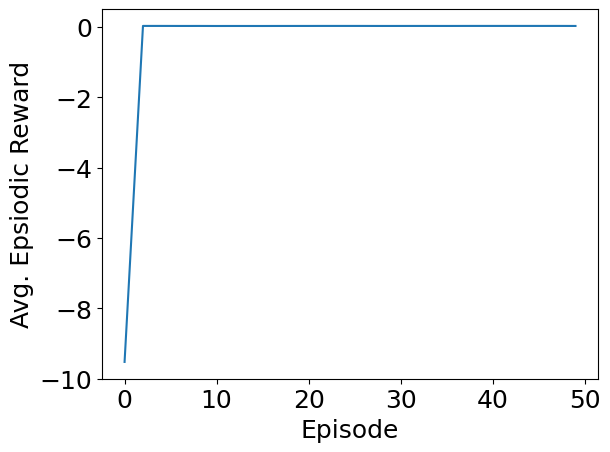

In [11]:
buffer = Buffer(50000, 1)
ep_reward_list = []
avg_reward_list = []
for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done = env.step(action[0])
        buffer.record((prev_state, action[0], np.mean(reward), state))
        episodic_reward += reward
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        if done:
            break
        prev_state = state
    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-2:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [12]:
from matplotlib import animation
def compute_animation_frames(environment):
    frame = []
    for _ in range(1):
        time_step = env.reset()
        while True:
            action = policy(tf_prev_state, ou_noise)
            state, reward, done, info = env.step(action[0])
            img = environment.render()
            frame.append(img)
            if done: break
    return frame

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=100):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [13]:
frames = compute_animation_frames(env)

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
plot_animation(frames)